In [46]:
import numpy as np
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1" # important to enable OpenEXR support, must be set before importing cv2

import cv2
import imageio
from matplotlib import pyplot as plt

Define file paths

In [47]:
NUM_IMAGES = 160

#! remember to add "/" to folder path at the end
camera_calibration_file_path = "./Camera/MeshroomCache/CameraCalibration/iPhone13_short/cameraCalibration.cal" # iPhone 13 calibrated file

meshroom_depth_map_folder_path = "./dataset/iPhone13/red_bird/meshroom_files/downsampled_with_depth/MeshroomCache/DepthMap/aaca30ac52cf6ffa4827b63b1c409ffd5e91f233/" # this should appear after completing the Depth Filter node of Meshroom
estimated_depth_map_input_folder_path = "./dataset/iPhone13/red_bird/downsampled_160/depth/" # depth map from Monodepth2
estimated_depth_map_output_folder_path = "./dataset/iPhone13/red_bird/meshroom_files/downsampled_with_depth/estimated_depth_map/" # output folder of undistorted .exr depths

Import Camera Intrinsics

In [48]:
cv_file = cv2.FileStorage(camera_calibration_file_path, cv2.FILE_STORAGE_READ)
camera_matrix = cv_file.getNode("camera_matrix").mat()
distortion_coefficients = cv_file.getNode("distortion_coefficients").mat()

print(camera_matrix)
print(distortion_coefficients)

[[1.68783953e+03 0.00000000e+00 9.64136795e+02]
 [0.00000000e+00 1.69268063e+03 5.43510465e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.26674297]
 [-2.05769186]
 [ 0.        ]
 [ 0.        ]
 [ 5.45942978]]


Inspect depth maps

In [49]:
def inspect_image(image_id, images):
    print(images[image_id].shape)
    plt.imshow(images[image_id]/images[image_id].max())
    plt.show()

Import depth from Meshroom depth_map

Output estimated depth map

In [50]:
meshroom_depth_maps = {}
meshroom_max_depths = {}
meshroom_mean_depths = {}
mono_depth_2_depth_maps_undistorted = {}

for i in range(NUM_IMAGES):
    meshroom_depth_map = cv2.imread(meshroom_depth_map_folder_path + str(i + 1) + "_depthMap.exr", cv2.IMREAD_UNCHANGED | cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if meshroom_depth_map is not None:
        meshroom_valid_indices = np.where(meshroom_depth_map != -1.0)
        meshroom_invalid_indices = np.where(meshroom_depth_map == 1.0)
        meshroom_depth_maps[i + 1] = meshroom_depth_map.clip(0.0, None)
        
        meshroom_max_depths[i + 1] = meshroom_depth_map.max()

        meshroom_mean_depth = meshroom_depth_map[meshroom_valid_indices].mean() # to get the mean of valid pixels' locations
        meshroom_mean_depths[i + 1] = meshroom_mean_depth


        estimated_depth_path = estimated_depth_map_input_folder_path + "img" + str(i + 1).zfill(4) + "_disp.jpeg"
        estimated_depth_map = cv2.cvtColor(cv2.imread(estimated_depth_path , cv2.IMREAD_UNCHANGED | cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH), cv2.COLOR_BGR2GRAY).astype('float32') # change to float 32 type
        estimated_depth_map = estimated_depth_map.clip(0.0, None) # limit depth to be larger than 0
        estimated_depth_map /= estimated_depth_map.mean() / meshroom_mean_depth # fix depth scales
        estimated_depth_map = cv2.undistort(estimated_depth_map, camera_matrix, distortion_coefficients) # undistortion
        mono_depth_2_depth_maps_undistorted[i + 1] = estimated_depth_map
        cv2.imwrite(estimated_depth_map_output_folder_path + str(i + 1) + "_depthMap.png", estimated_depth_map)

        estimated_depth_map[meshroom_invalid_indices] = -1.0 # input invalid pixels
        cv2.imwrite(estimated_depth_map_output_folder_path + str(i + 1) + "_depthMap.exr", estimated_depth_map)
        

# print("mean depth:", np.array(list(meshroom_max_depths.values())).mean())
# print("mean depths:", meshroom_mean_depths)

# print("max depth:", np.array(list(meshroom_max_depths.values())).max())
# print("max depths:", meshroom_max_depths)

(1080, 1920)


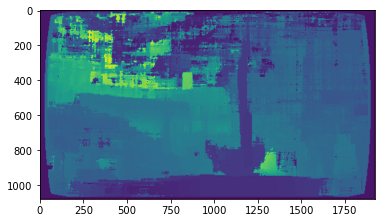

(1080, 1920)


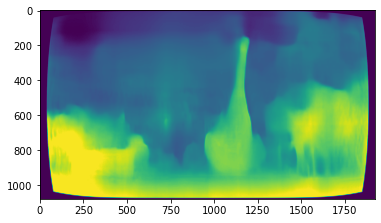

3.1022
3.368615


In [51]:
inspect_image(100, meshroom_depth_maps)
inspect_image(100, mono_depth_2_depth_maps_undistorted)
print(mono_depth_2_depth_maps_undistorted[100].mean())
print(meshroom_mean_depths[100])